## Part 2: Predicting mortality in ICUs
### Daniel Dastoor
### Part a:

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import roc_curve
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string, re, multiprocessing
from multiprocessing import Pool

In [2]:
class Data:
    def __init__(self, data, target):
        self.data = data
        self.target = target
    
class Dataset:
    def __init__(self, train: Data, test: Data):
        self.train = train
        self.test = test

In [3]:
dataset = pd.read_csv("~/csc2548_ml4h/adult_icu.gz", compression='gzip')

min_max_scaler = MinMaxScaler()
dataset.iloc[:,3:] = min_max_scaler.fit_transform(dataset.iloc[:,3:].values.astype(float))

trainset = dataset[dataset.train == 1].copy()
trainset.reset_index(drop=True, inplace=True)
trainset.drop(["train", "subject_id", "icustay_id"], axis=1, inplace=True)
target = trainset.pop("mort_icu")
train = Data(trainset, target)

testset = dataset[dataset.train == 0].copy()
testset.reset_index(drop=True, inplace=True)
testset.drop(["train", "subject_id", "icustay_id"], axis=1, inplace=True)
target = testset.pop("mort_icu")
test = Data(testset, target)

adult_icu = Dataset(train, test)

In [5]:
logisticRegression = LogisticRegression(penalty='l2', solver='liblinear', max_iter=2000)
logisticRegression.fit(adult_icu.train.data.drop(["hadm_id"], axis=1), adult_icu.train.target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

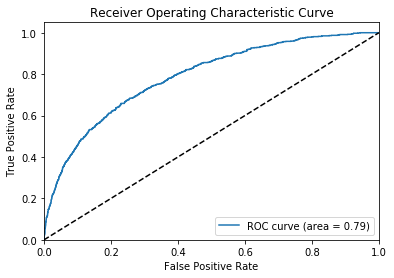

'AUC Score = 0.79'

In [6]:
prediction = logisticRegression.predict_proba(adult_icu.test.data.drop(["hadm_id"], axis=1))
fpr, tpr, thresholds = roc_curve(adult_icu.test.target.values, prediction[:, 1])
auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()
display("AUC Score = " + str(round(auc, 2)))

In [7]:
accuracy = logisticRegression.score(adult_icu.test.data.drop(["hadm_id"], axis=1), adult_icu.test.target) * 100
"Accuracy = " + str(round(accuracy, 2)) + "%"

'Accuracy = 90.84%'

#### Comment on model performance:
Initially, one could come to the quick conclusion that this model's performance is good, due to the "accuracy" of 90.84%. However, there is a large amount of class imbalance in the dataset, and as such, it is more usefull to look at the AUC score for the model. From the model's AUC score of 0.79, one can get a better sense of how the model is not performing extraordinarily well. However, with futher tuning and optimization, there is some potential in the usefulness of logistic regression on this type of normalized data.

In [39]:
feature_coefs = pd.Series(logisticRegression.coef_[0], index=adult_icu.train.data.drop(["hadm_id"], axis=1).columns)
feature_coefs.sort_values(ascending=False, inplace=True)
display("Top 5 risk factors of mortality:")
display(feature_coefs.head(5).index.tolist())
display("Lowest 5 risk factors of mortality:")
display(feature_coefs.tail(5).index.tolist())

'Top 5 risk factors of mortality:'

['bilirubin', 'lactate', 'tempc_max', 'meanbp_mean', 'bun']

'Lowest 5 risk factors of mortality:'

['albumin', 'sysbp_min', 'platelet', 'tempc_mean', 'tempc_min']

#### Top 5 risk factors of mortality:

bilirubin: Forms after red blood cells break down, travelling through the liver, gallbladder, and digestive tract before excretion. Levels of high bilirubin, hyperbilirubinemia, can be indicative of a host of issues, many of which are serious.

lactate: Lactate or lactic acid levels are elevated in conditions of strenuous exercise, or life-threatening conditions including heart failure, sepsis, and shock. High levels of lactate can further indicate a lack of oxygen in the blood (hypoxia).

tempc_max: Maximum temprature of patient. A high maximum temprature can indicate serious issues.

meanbp_mean: Average heart rate of patient. A high average heart rate can indicate serious issues.

bun: Blood urea nitrogen measures the amount of urea nitrogen found in blood. This is an indication of kidney health. A high bun can be indicative of kidney or heart failure.

#### Lowest 5 risk factors of mortality:

albumin: Albumin is an abundant protein. High levels of albumin are caused by dehydration.

sysbp_min: Minimum systolic blood pressure. Mean and max bp are much more indicative of issues.

platelet: Platelets are tiny fragments of cells essential for normal blood clotting. Extreme variations in amount of platelet are not very common.

tempc_mean: Average temprature of patient. Max temprate of pation is much more indicative of issues.

tempc_min: Minimum temprature of patient. Max temprate of pation is much more indicative of issues.

### Part b:

In [4]:
dataset = pd.read_csv("~/csc2548_ml4h/adult_notes.gz", compression='gzip')
dataset = dataset[~pd.isnull(dataset.chartext)]

trainset = dataset[dataset.train == 1].copy()
trainset.reset_index(drop=True, inplace=True)
trainset.drop(["train", "subject_id", "icustay_id"], axis=1, inplace=True)
target = trainset.pop("mort_icu")
train = Data(trainset, target)

testset = dataset[dataset.train == 0].copy()
testset.reset_index(drop=True, inplace=True)
testset.drop(["train", "subject_id", "icustay_id"], axis=1, inplace=True)
target = testset.pop("mort_icu")
test = Data(testset, target)

adult_notes = Dataset(train, test)

In [11]:
stopwordList = stopwords.words("english")

def tokenize(s):
    return [j for j in [re.sub("\W+", '', i) for i in word_tokenize(s.lower())] 
            if j not in stopwordList and j != '']

vectorizer = TfidfVectorizer(tokenizer=tokenize)
vectorizer.fit(adult_notes.train.data.chartext)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize at 0x7f5bcd4de6a8>, use_idf=True,
        vocabulary=None)

In [12]:
num_cores = multiprocessing.cpu_count()
num_partitions = num_cores - 1 if num_cores > 1 else 1

# parallelize_dataframe adapted from 
# https://stackoverflow.com/questions/28396957/sklearn-tfidf-vectorizer-to-run-as-parallel-jobs
def parallelize_dataframe(df, func):
    a = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = sp.sparse.vstack(pool.map(func, a), format='csr')
    pool.close()
    pool.join()
    return df

train_transformed = parallelize_dataframe(adult_notes.train.data.chartext, vectorizer.transform)
test_transformed = parallelize_dataframe(adult_notes.test.data.chartext, vectorizer.transform)

In [13]:
logisticRegression_b = LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000)
logisticRegression_b.fit(train_transformed, adult_notes.train.target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

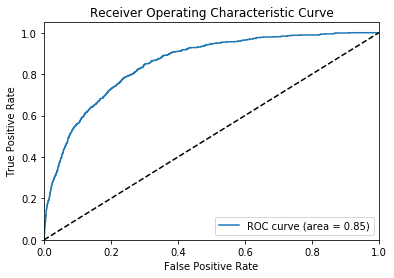

'AUC Score = 0.85'

In [14]:
prediction_b = logisticRegression_b.predict_proba(test_transformed)
fpr_b, tpr_b, thresholds_b = roc_curve(adult_notes.test.target.values, prediction_b[:, 1])
auc_b = metrics.auc(fpr_b, tpr_b)

plt.figure()
plt.plot(fpr_b, tpr_b, label='ROC curve (area = %0.2f)' % auc_b)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()
display("AUC Score = " + str(round(auc_b, 2)))

In [15]:
accuracy_b= logisticRegression_b.score(test_transformed, adult_notes.test.target.values) * 100
"Accuracy = " + str(round(accuracy_b, 2)) + "%"

'Accuracy = 91.48%'

In [16]:
feature_coefs_b = pd.Series(logisticRegression_b.coef_[0], index=vectorizer.get_feature_names())
feature_coefs_b.sort_values(ascending=False, inplace=True)
display("Top 5 risk factors of mortality:")
display(feature_coefs_b.head(5).index.tolist())
display("Lowest 5 risk factors of mortality:")
display(feature_coefs_b.tail(5).index.tolist())

'Top 5 risk factors of mortality:'

['prognosis', 'cmo', 'corneal', 'dnr', 'family']

'Lowest 5 risk factors of mortality:'

['intact', 'mae', 'clear', 'diet', 'extubation']

#### Comment on model performance:
The risk factors found do make sense, especially the top 5 risk factors of mortality.
The AUC of this model (0.85) is much more promising than that of the logicstic regression model run on normalized data. This could be as the notes for the patients captured a high amount of information and variability.

### Part c:

In [74]:
combined_trainset = pd.merge(adult_icu.train.data.join(adult_icu.train.target), adult_notes.train.data, on="hadm_id")
combined_target = combined_trainset.pop("mort_icu")
combined_train = Data(combined_trainset, combined_target)

combined_testset = pd.merge(adult_icu.test.data.join(adult_icu.test.target), adult_notes.test.data, on="hadm_id")
combined_target = combined_testset.pop("mort_icu")
combined_test = Data(combined_testset, combined_target)

combined = Dataset(combined_train, combined_test)

combined_train_transformed = parallelize_dataframe(combined.train.data.chartext, vectorizer.transform)
combined_test_transformed = parallelize_dataframe(combined.test.data.chartext, vectorizer.transform)

In [116]:
combined.train.data.drop(["hadm_id", "chartext"], axis=1, inplace=True)
combined.test.data.drop(["hadm_id", "chartext"], axis=1, inplace=True)

combined_sparse_train = sp.sparse.hstack((combined.train.data.values, combined_train_transformed))
combined_sparse_test = sp.sparse.hstack((combined.test.data.values, combined_test_transformed))

logisticRegression_c = LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000)
logisticRegression_c.fit(combined_sparse_train, combined.train.target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

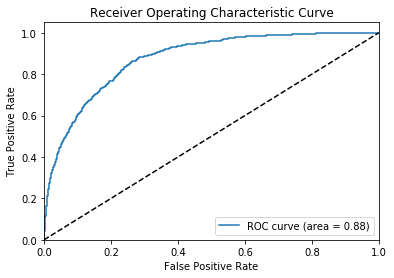

'AUC Score = 0.88'

In [121]:
prediction_c = logisticRegression_c.predict_proba(combined_sparse_test)
fpr_c, tpr_c, thresholds_c = roc_curve(combined.test.target.values, prediction_c[:, 1])
auc_c = metrics.auc(fpr_c, tpr_c)

plt.figure()
plt.plot(fpr_c, tpr_c, label='ROC curve (area = %0.2f)' % auc_c)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()
display("AUC Score = " + str(round(auc_c, 2)))

In [122]:
accuracy_c = logisticRegression_c.score(combined_sparse_test, combined.test.target.values) * 100
"Accuracy = " + str(round(accuracy_c, 2)) + "%"

'Accuracy = 91.94%'

In [123]:
feature_coefs_c = pd.Series(logisticRegression_c.coef_[0], index=(combined.train.data.columns.values.tolist()+vectorizer.get_feature_names()))
feature_coefs_c.sort_values(ascending=False, inplace=True)
display("Top 5 risk factors of mortality:")
display(feature_coefs_c.head(5).index.tolist())
display("Lowest 5 risk factors of mortality:")
display(feature_coefs_c.tail(5).index.tolist())

'Top 5 risk factors of mortality:'

['prognosis', 'corneal', 'stimuli', 'family', 'cmo']

'Lowest 5 risk factors of mortality:'

['good', 'diet', 'mae', 'clear', 'extubation']

#### Comment on how the two sources of data affect the model:

While the clinical notes were an excellent source of data for a logictic regression model resulting in an AUC of 0.85, adding all of the numerical variables to the data did not result in much of an improvement (AUC increase of 0.03). Furthermore, one does not see any of the variables from the numerical data included in the top 5 or lowest 5 risk factors of mortality, showing that most of the decision is still influenced by the clinical notes data.